# Reference links:

- https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15
- [Image Preprocessing](https://keras.io/api/preprocessing/image/)
- [Overfitting & Underfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
- [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

## Also check the following callbacks:

- ModelCheckpointing

https://www.tensorflow.org/tutorials/keras/save_and_load

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

- EarlyStopping
- tensorboard

## Additional Information About Hardware:

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from tensorflow.python.client import  device_lib
device_lib.list_local_devices()

In [ ]:
!cat /proc/cpuinfo/

In [ ]:
!cat /proc/meminfo

## Mounting Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Creation Code:

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
tf.__version__

'2.4.0'

In [5]:
os.chdir('/content/drive/MyDrive/dogCatClassifier') # Only un-comment if rumming in google colab

In [6]:
os.getcwd()

'/content/drive/MyDrive/dogCatClassifier'

### Reading Data:

In [7]:
data_path_train = os.path.join(os.getcwd(), 'datasets', 'extracted_data', 'train') 
data_path_train

'/content/drive/MyDrive/dogCatClassifier/datasets/extracted_data/train'

In [24]:
# Data Preprocessing:

#1. Define image preprocessor for train
img_train_read = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range = [0.7, 1.0],
                                   rotation_range = 20,
                                   validation_split=0.2
                              )

In [25]:
# Training Dataset:

train_generator = img_train_read.flow_from_directory(
    data_path_train,
    target_size = (150, 150),
   color_mode = 'rgb',
   batch_size = 64,
   class_mode = 'binary',
   shuffle = True,
    subset='training') # set as training data

Found 20001 images belonging to 2 classes.


In [26]:
# Validation Dataset:

validation_generator = img_train_read.flow_from_directory(
    
    data_path_train,      # same directory as training data
    
    target_size = (150, 150),
   color_mode = 'rgb',
   batch_size = 64,
   class_mode = 'binary',
   shuffle = True,
    subset='validation')         # set as validation data

Found 5000 images belonging to 2 classes.


In [1]:
# # Preprocessing the Test set

# data_path_test = os.path.join(os.getcwd(), 'datasets', 'extracted_data', 'test')
# test_datagen = ImageDataGenerator(rescale = 1./255)
# test_set = test_datagen.flow_from_directory(data_path_test,
#                                             target_size = (150, 150),
#                                            color_mode = 'rgb',
#                                            batch_size = 64,
#                                            class_mode = 'binary',
#                                            shuffle = True)

## Creating CNN:

In CNN does increasing the kernel_size result in underfitting or overfitting?

It depends on the images, if you needed a lot of details from the image you don't need to increase your kernel size. ... Smaller kernel will gives you a lot of details, it can lead you to overfitting, but larger kernel will gives you loss a lot of details, it can lead you to underfitting

In [27]:
cnn = tf.keras.models.Sequential()


# Adding Layers.
cnn.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=[150, 150, 3], activation='relu'))  # kernel_initializer not required

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [28]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               11215104  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
cnn.layers

In [30]:
layer1 = cnn.layers[1]

In [31]:
layer1.get_weights()

[]

In [32]:
# Model Checkpointing for saving model every epochs

filepath_chpt = os.path.join(os.getcwd(), 'tmp', 'chpt-{epoch:02d}-{val_accuracy:.5f}.hdf5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                  filepath=filepath_chpt,
                                   monitor='val_loss',
                                   verbose=0,
                                   save_freq='epoch',
                                   save_best_only=False,
                                   save_weights_only=False,
                                   mode='auto')

In [ ]:
# Part 3 - Training the CNN --10.18 am

# Compiling the CNN

# LOSS_FUNCTION = "sparse_categorical_crossentropy"     # or use => tf.losses.sparse_categorical_crossentropy
# OPTIMIZER = "SGD"               # or use with custom learning rate=> tf.keras.optimizers.SGD(0.02)
# METRICS = ["accuracy"]

cnn.compile(optimizer = 'adam',
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [33]:
# Training the CNN on the Training set and evaluating it on the Test set
cnn.fit(x = train_generator,
        epochs = 4,
        batch_size = 64,
        validation_data= validation_generator,
        callbacks=[model_checkpoint_callback])

Epoch 1/4
313/313 [==============================] - 4310s 14s/step - loss: 0.8105 - accuracy: 0.5805 - val_loss: 0.5540 - val_accuracy: 0.7228
Epoch 2/4
313/313 [==============================] - 664s 2s/step - loss: 0.5682 - accuracy: 0.7054 - val_loss: 0.5323 - val_accuracy: 0.7288
Epoch 3/4
313/313 [==============================] - 668s 2s/step - loss: 0.5287 - accuracy: 0.7360 - val_loss: 0.4986 - val_accuracy: 0.7582
Epoch 4/4
313/313 [==============================] - 670s 2s/step - loss: 0.4853 - accuracy: 0.7660 - val_loss: 0.4768 - val_accuracy: 0.7734


In [35]:
# Assigning variable to the history returned by fit function.
history = _

In [36]:
history.params

{'epochs': 4, 'steps': 313, 'verbose': 1}

In [72]:
chart = pd.DataFrame(history.history)
chart

,loss,accuracy,val_loss,val_accuracy
0,0.659772,0.633168,0.553994,0.7228
1,0.556409,0.712814,0.532322,0.7288
2,0.513469,0.748163,0.498645,0.7582
3,0.484697,0.765062,0.476762,0.7734


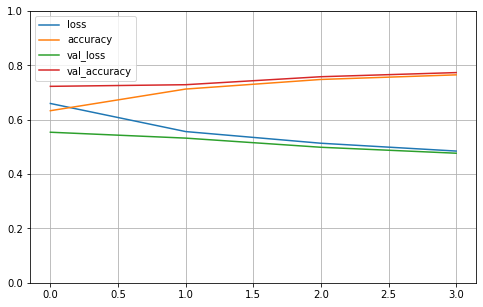

In [41]:
# Plotting performance improvement per epoch

pd.DataFrame(chart).plot(figsize=(8, 5))    # Width, Height
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Saving & Loading model:

In [61]:
os.makedirs(os.path.join(os.getcwd(), 'saved_models'), exist_ok=True)
cnn.save('saved_models/1_cnn15epochs.h5')

In [42]:
# Deletes the model data
del cnn

In [43]:
cnn

NameError: ignored

In [44]:
cnn = tf.keras.models.load_model('saved_models/1_cnn15epochs.h5')

In [45]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               11215104  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('datasets/extracted_data/test/0/95.jpg', target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
print(result)

[[0.99951315]]


In [ ]:
if result >= 0.5:
    print('Dog')
else:
    print('Cat')

Dog


# Continue model training from saved model:

In [46]:
# Training the CNN for more epochs and using the already learned data
cnn.fit(x = train_generator, epochs = 5, validation_data= validation_generator)

Epoch 1/5
313/313 [==============================] - 658s 2s/step - loss: 0.4725 - accuracy: 0.7719 - val_loss: 0.4700 - val_accuracy: 0.7708
Epoch 2/5
313/313 [==============================] - 658s 2s/step - loss: 0.4485 - accuracy: 0.7885 - val_loss: 0.4457 - val_accuracy: 0.8028
Epoch 3/5
313/313 [==============================] - 656s 2s/step - loss: 0.4357 - accuracy: 0.7966 - val_loss: 0.4454 - val_accuracy: 0.7992
Epoch 4/5
313/313 [==============================] - 656s 2s/step - loss: 0.4170 - accuracy: 0.8072 - val_loss: 0.4143 - val_accuracy: 0.8052
Epoch 5/5
313/313 [==============================] - 658s 2s/step - loss: 0.4070 - accuracy: 0.8126 - val_loss: 0.4363 - val_accuracy: 0.7932


In [47]:
cnn.save('saved_models/CNN_epochs_9_val_acc_7980.h5')

In [48]:
history1=_

In [73]:
chart_new = pd.DataFrame(history1.history)
chart_new

,loss,accuracy,val_loss,val_accuracy
0,0.472511,0.771911,0.470020,0.7708
1,0.448501,0.788511,0.445666,0.8028
2,0.435729,0.796610,0.445401,0.7992
3,0.417044,0.807210,0.414341,0.8052
4,0.406995,0.812609,0.436279,0.7932


In [74]:
chart = chart.append(chart_new, ignore_index=True)
chart

,loss,accuracy,val_loss,val_accuracy
0,0.659772,0.633168,0.553994,0.7228
1,0.556409,0.712814,0.532322,0.7288
2,0.513469,0.748163,0.498645,0.7582
3,0.484697,0.765062,0.476762,0.7734
4,0.472511,0.771911,0.470020,0.7708
5,0.448501,0.788511,0.445666,0.8028
6,0.435729,0.796610,0.445401,0.7992
7,0.417044,0.807210,0.414341,0.8052
8,0.406995,0.812609,0.436279,0.7932


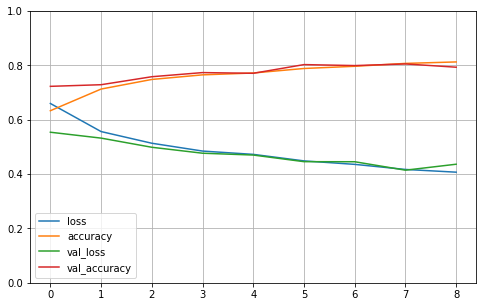

In [75]:
pd.DataFrame(chart).plot(figsize=(8, 5))    # Width, Height
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [63]:
# Another Iteration of 6 epochs -- total 15
cnn = tf.keras.models.load_model('saved_models/CNN_epochs_9_val_acc_7932.h5')

cnn.fit(x = train_generator,
        epochs = 6,
        batch_size = 64,
        validation_data= validation_generator,
        callbacks=[model_checkpoint_callback])

Epoch 1/6
313/313 [==============================] - 658s 2s/step - loss: 0.3938 - accuracy: 0.8224 - val_loss: 0.4076 - val_accuracy: 0.8136
Epoch 2/6
313/313 [==============================] - 661s 2s/step - loss: 0.3859 - accuracy: 0.8238 - val_loss: 0.4316 - val_accuracy: 0.7936
Epoch 3/6
313/313 [==============================] - 659s 2s/step - loss: 0.3758 - accuracy: 0.8304 - val_loss: 0.3997 - val_accuracy: 0.8222
Epoch 4/6
313/313 [==============================] - 661s 2s/step - loss: 0.3638 - accuracy: 0.8372 - val_loss: 0.4104 - val_accuracy: 0.8130
Epoch 5/6
313/313 [==============================] - 660s 2s/step - loss: 0.3523 - accuracy: 0.8453 - val_loss: 0.3953 - val_accuracy: 0.8234
Epoch 6/6
313/313 [==============================] - 659s 2s/step - loss: 0.3445 - accuracy: 0.8514 - val_loss: 0.3995 - val_accuracy: 0.8274


In [64]:
history2 = _

In [76]:
chart_new = pd.DataFrame(history2.history)
chart = chart.append(chart_new, ignore_index=True)
chart

,loss,accuracy,val_loss,val_accuracy
0,0.659772,0.633168,0.553994,0.7228
1,0.556409,0.712814,0.532322,0.7288
2,0.513469,0.748163,0.498645,0.7582
3,0.484697,0.765062,0.476762,0.7734
4,0.472511,0.771911,0.470020,0.7708
5,0.448501,0.788511,0.445666,0.8028
6,0.435729,0.796610,0.445401,0.7992
7,0.417044,0.807210,0.414341,0.8052
8,0.406995,0.812609,0.436279,0.7932
9,0.393792,0.822359,0.407620,0.8136


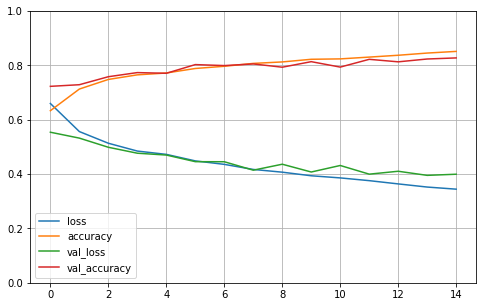

In [77]:
pd.DataFrame(chart).plot(figsize=(8, 5))    # Width, Height
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [67]:
cnn.save('saved_models/CNN_epochs_15_val_acc_8274.h5')

In [68]:
# Another Iteration of 6 epochs -- total 21 epochs
cnn = tf.keras.models.load_model('saved_models/CNN_epochs_15_val_acc_8274.h5')

cnn.fit(x = train_generator,
        epochs = 6,
        batch_size = 64,
        validation_data= validation_generator,
        callbacks=[model_checkpoint_callback])

Epoch 1/6
313/313 [==============================] - 657s 2s/step - loss: 0.3372 - accuracy: 0.8487 - val_loss: 0.3722 - val_accuracy: 0.8380
Epoch 2/6
313/313 [==============================] - 659s 2s/step - loss: 0.3321 - accuracy: 0.8550 - val_loss: 0.4308 - val_accuracy: 0.7986
Epoch 3/6
313/313 [==============================] - 665s 2s/step - loss: 0.3188 - accuracy: 0.8615 - val_loss: 0.3749 - val_accuracy: 0.8380
Epoch 4/6
313/313 [==============================] - 668s 2s/step - loss: 0.3126 - accuracy: 0.8641 - val_loss: 0.3755 - val_accuracy: 0.8372
Epoch 5/6
313/313 [==============================] - 678s 2s/step - loss: 0.3106 - accuracy: 0.8662 - val_loss: 0.3916 - val_accuracy: 0.8320
Epoch 6/6
313/313 [==============================] - 669s 2s/step - loss: 0.3033 - accuracy: 0.8697 - val_loss: 0.3881 - val_accuracy: 0.8270


Here the model gets Overfitted....

In [69]:
history3 = _

,loss,accuracy,val_loss,val_accuracy
0,0.659772,0.633168,0.553994,0.7228
1,0.556409,0.712814,0.532322,0.7288
2,0.513469,0.748163,0.498645,0.7582
3,0.484697,0.765062,0.476762,0.7734
4,0.472511,0.771911,0.470020,0.7708
5,0.448501,0.788511,0.445666,0.8028
6,0.435729,0.796610,0.445401,0.7992
7,0.417044,0.807210,0.414341,0.8052
8,0.406995,0.812609,0.436279,0.7932
9,0.472511,0.771911,0.470020,0.7708


From the chart we find that 17 iterations give the best result.


In [78]:
chart_new = pd.DataFrame(history3.history)
chart = chart.append(chart_new, ignore_index=True)
chart

,loss,accuracy,val_loss,val_accuracy
0,0.659772,0.633168,0.553994,0.7228
1,0.556409,0.712814,0.532322,0.7288
2,0.513469,0.748163,0.498645,0.7582
3,0.484697,0.765062,0.476762,0.7734
4,0.472511,0.771911,0.470020,0.7708
5,0.448501,0.788511,0.445666,0.8028
6,0.435729,0.796610,0.445401,0.7992
7,0.417044,0.807210,0.414341,0.8052
8,0.406995,0.812609,0.436279,0.7932
9,0.393792,0.822359,0.407620,0.8136


In [79]:
history3.params

{'epochs': 6, 'steps': 313, 'verbose': 1}

In [71]:
cnn.save('saved_models/CNN_epochs_21_val_acc_8380.h5')

# Saving & reading CSV files:

In [81]:
chart.to_csv("epoch_accuracy_data.csv", index=False)

In [83]:
acc_chart = pd.read_csv("epoch_accuracy_data.csv")
acc_chart

,loss,accuracy,val_loss,val_accuracy
0,0.659772,0.633168,0.553994,0.7228
1,0.556409,0.712814,0.532322,0.7288
2,0.513469,0.748163,0.498645,0.7582
3,0.484697,0.765062,0.476762,0.7734
4,0.472511,0.771911,0.470020,0.7708
5,0.448501,0.788511,0.445666,0.8028
6,0.435729,0.796610,0.445401,0.7992
7,0.417044,0.807210,0.414341,0.8052
8,0.406995,0.812609,0.436279,0.7932
9,0.393792,0.822359,0.407620,0.8136


The 15th index (16th epoch) appears to be the best as its having the least validation loss.

But the 17th index is also good.

After that we encounter **Overfitting**.

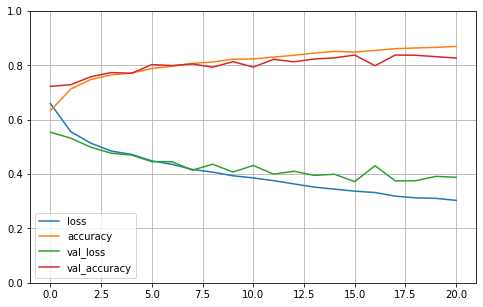

In [80]:
pd.DataFrame(chart).plot(figsize=(8, 5))    # Width, Height
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()